Made under Python 3 environment, Google Colab.

Hi!

So we begin with importing some things we need.

I'm importing the file vgg16.py, a well documented file as to import and use the vgg16.tfmodel

See the vgg16.py file for documentaion for used functions.

Resources used :

Youtube video by Hvass Technologies.

Andrew Ng lectures on Neural Networks.

In [0]:
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
import os
work_dir = "/content/"
os.chdir(work_dir)

In [3]:
import vgg16
vgg16.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


I did define my functions first.

As I made this in Google Colab, I did upload *my* **style_image** and **content_image** into it. If you want to use any other image, just provide the links to them, or you might even use Google Drive.



I used 512x512 images. Resize if you want to.

Subsequently, the images will be converted to a matrix of entries with type float.

In [4]:
"""
  def resize(image, size):
    shape = image.get_shape() 
"""

'\n  def resize(image, size):\n  \n'

The funtion to print the image on-screen.

In [0]:
def put_on_screen(image):
  image = np.clip(image, 0.0, 255.0)
  image = image.astype(np.uint8)
  image = PIL.Image.fromarray(image)
  display (image)

I won't go exactly with the paper. I'd make two loss functions for now, I do not understand the thing with denoise, and related losses.

*content_loss*, and *style_loss*...

A front-side, but now too front-sided, layer would be efficient for the *content_losses*, as this layer would bring in the more general features of the image like edges and light differences...

The layers at the back involve much higher features like faces, and eyes.

In [0]:
def content_image_loss(session, model, content_image, layer_ids):
  
  feed_dict = model.create_feed_dict(image = content_image)
  layers = model.get_layer_tensors(layer_ids = layer_ids)
  
  value_in_layers = session.run(layers, feed_dict = feed_dict)
  
  with model.graph.as_default():
    #I did not know that model.graph needed to be explicitly set as_default.
    #I don't know why.
    iterator = zip(value_in_layers, layers)                #zip makes a set of the corresponding elements in the two lists
  
    content_loss = []
  
    for value, layer in iterator:
      loss = tf.reduce_mean(tf.square(value - layer))        #mean squared error
      content_loss.append(loss)
    
    loss = tf.reduce_mean(content_loss)                      #total loss is the average of all layer losses
  return(loss)

According to the explanation by Andrew Ng, the gram matrix is what the difference is measured against.  

In [0]:
#Consider the layer has 5 channels
#num_channels = 5
#we need the product of the activation_values of all points through all these channels. 
#thus, it is reshaped to a [(suitable_size)xnum_channels] matrix 

def gram_matrix(feature):
  shape = feature.get_shape()
  num_channels = int(shape[3])
  
  matrix = tf.reshape(feature, shape = [-1,num_channels])
  gram = tf.matmul(tf.transpose(matrix), matrix)
  
  return(gram)

There is no such thing like feature level for *style_image*, all the layers can therefore be included for good results.

In [0]:
def style_image_loss(session, model, style_image, layer_ids):
  
  feed_dict = model.create_feed_dict(image = style_image)
  layers = model.get_layer_tensors(layer_ids = layer_ids)
  
  with model.graph.as_default():
    gram_for_layer = []
    for layer in layers:
      gram_for_layer.append(gram_matrix(layer))            ###################
      
    value_in_layers = session.run(gram_for_layer, feed_dict = feed_dict)
    
    iterator = zip(value_in_layers, gram_for_layer)
    
    style_loss = []
    
    for value, layer in iterator:
      loss = tf.reduce_mean(tf.square(value - layer))        #mean squared error
      style_loss.append(loss)
      
    loss = tf.reduce_mean(style_loss)
  return(loss)

Now, constructing the *style_transfer* function.

In [0]:
def style_transfer(style_image, content_image, 
                   style_id, content_id,
                   style_loss_wt = 10, content_loss_wt = 1.5,  
                   n_iterations = 100, step = 10 ):
  
  model = vgg16.VGG16()
  session = tf.InteractiveSession(graph = model.graph)
  
  c_loss = content_image_loss(session = session, model = model, 
                              content_image = content_image, layer_ids = content_id)
  s_loss = style_image_loss(session = session, model = model, 
                            style_image = style_image, layer_ids = style_id)
  
  c_loss_update = tf.Variable(1e-10, name = "c_loss_update")
  s_loss_update = tf.Variable(1e-10, name = "s_loss_update")
  ##########################################################################
  session.run([c_loss_update.initializer, s_loss_update.initializer])
  
  update_c_loss = c_loss_update.assign( 1.0 / (c_loss + 1e-10))
  update_s_loss = s_loss_update.assign( 1.0 / (s_loss + 1e-10))
  
  total_loss = style_loss_wt* s_loss * update_s_loss + \
               content_loss_wt * c_loss * update_c_loss
  
  gradient = tf.gradients(total_loss, model.input)            #returns the derivative of total_loss with respect to
                                                              #the model's imput parameters
  
  run_list = [gradient, update_c_loss, update_s_loss]
  
  result = np.random.rand(*content_image.shape) + 128         #128 is midway between 0 and 255, min and max values
                                                              #thus easier to reach an optimum place
  
  for i in range(0, n_iterations):
    feed_dict = model.create_feed_dict(image = result)
    grad, c_loss_a, s_loss_a = session.run(run_list, feed_dict = feed_dict)
    
    grad = np.squeeze(grad)
    result -= grad * step * (1/(np.std(grad) + 1e-10))        #can also use np.mean, this is meant just for normaliztion
                                                              #and the 1e-10 is to avoid division by zero, in case
    
    result = np.clip(result, 0.0, 225.0)                      #this is done to ensure image_values are between 0 and 255
    
    if (i % 10 == 0) or (i == n_iterations - 1):
      print("Iteration cycle ", i)
    
  put_on_screen(result)
  session.close()
  
  return (result)

trying this out...

In [0]:
style_image= PIL.Image.open('white.jpg')
#style_image = Image.open('your_link_here')

content_image = PIL.Image.open('me.jpg')
#style_image = Image.open('your_link_here')

In [0]:
style_image = np.float32(style_image) 
content_image = np.float32(content_image)     

VGG16 has 13 convolutional layers, all 13 or some of them can be chosen...

In [0]:
content_ids = [4]
style_ids = list(range(13))
#style_ids = [5, 6, 7, 8, 9, 10]

If you choose to do it with a GPU, set a high number of iterations, about 1500...

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 99


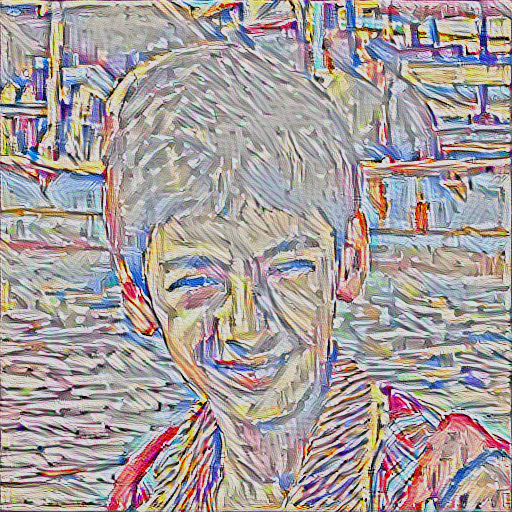

In [37]:
img = style_transfer(style_image = style_image, 
                     content_image = content_image, 
                     style_id = style_ids, 
                     content_id = content_ids,
                     style_loss_wt = 10, 
                     content_loss_wt = 2,  
                     n_iterations = 100, 
                     step = 10 )